#  Iligan City Fire Response Optimization (2030 Forecast)

This notebook determines the **optimal air-based fire station location** in Iligan City that minimizes **Estimated Time of Arrival (ETA)** to all barangays using projected 2030 population data.

We simulate:
-  Land-based response from existing fire stations (using road network)
-  Air-based response from candidate sites (using Euclidean distance)

The model outputs the optimal airbase location that yields the lowest **population-weighted ETA** across all barangays.


##  Datasets Used

| File | Description |
|------|-------------|
| `newforecast_output_2030.xls` | Barangay-level population forecast (2030) |
| `merged_barangay_centroids_44.csv` | Geographic centroids (lat/lon) per barangay |
| `IliganData_Stations.xlsx` | Existing fire station coordinates |
| `iligan_roads_buffer/edges.shp` | Road network edges (for land ETA computation) |


In [9]:
import os
base_path = "data"

import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# Load population forecast
pop2030_df = pd.read_excel(os.path.join(base_path, "newforecast_output_2030_clean.xlsx"))


# Load barangay centroids (lat/lon)
centroids_df = pd.read_csv(os.path.join(base_path, "merged_barangay_centroids_44.csv"))


# Load land-based fire station locations
stations_df = pd.read_excel(os.path.join(base_path, "IliganData_Stations.xlsx"))



##  Step 1: Merge Barangay Coordinates and Population Forecast

We merge 2030 population data with barangay centroids using the `Barangay` field to create a complete working dataset.


In [11]:
# Merge population and coordinates
barangay_df = pd.merge(centroids_df, pop2030_df, on="Barangay", how="inner")

# Rename for clarity
barangay_df.rename(columns={"Latitude": "Lat", "Longitude": "Lon", "Population_2030": "Pop2030"}, inplace=True)

# Preview
barangay_df.head()


,Barangay,Lat,Lon,Best_Model,RMSE,Projected_2030
0,Abuno,8.182706,124.272597,Linear,497.75,6400
1,Acmac,8.274926,124.267237,Linear,71.75,7808
2,Bagong Silang,8.241025,124.252145,Linear,414.27,7277
3,Bonbonon,8.276874,124.288169,Exponential,180.03,2461
4,Bunawan,8.183873,124.307443,Linear,153.76,2022


## Step 2: Load and Prepare Road Network

We load the road network shapefile (`edges.shp`) from the `iligan_roads_buffer` directory and project it into a metric coordinate system (UTM Zone 51N) to ensure that all distance calculations are in meters.


In [13]:
# Load shapefile containing road edges
edges_gdf = gpd.read_file(os.path.join(base_path, "full_iligan_roads_buffer", "edges.shp"))


# Project to UTM Zone 51N (EPSG:32651) for accurate distance measurement
edges_gdf = edges_gdf.to_crs(epsg=32651)

# Preview
edges_gdf.head()


,u,v,key,osmid,highway,lanes,name,oneway,reversed,length,maxspeed,ref,bridge,junction,access,width,geometry
0,245363085,1727288007,0,88790376,secondary,2,New Capitol Complex Road,False,True,100.701252,None,None,None,None,None,None,"LINESTRING (641174.686 884957.941, 641162.302 ..."
1,245363085,1030435047,0,229394196,secondary,2,Cadre Road,False,True,330.111584,40,None,None,None,None,None,"LINESTRING (641174.686 884957.941, 641177.511 ..."
2,245363085,1030436605,0,692493522,trunk,2,Amai Pakpak Avenue,False,False,135.352530,None,77,None,None,None,None,"LINESTRING (641174.686 884957.941, 641147.769 ..."
3,245363085,7981395224,0,692493522,trunk,2,Amai Pakpak Avenue,False,True,99.505344,None,77,None,None,None,None,"LINESTRING (641174.686 884957.941, 641230.047 ..."
4,245366634,8099897878,0,692493552,tertiary,None,Tipanoy Road,False,False,24.990711,None,None,None,None,None,None,"LINESTRING (638516.971 904758.848, 638509.394 ..."


## Step 3: Build NetworkX Graph from Road Edges

We build a weighted undirected graph from the shapefile using edge geometries. Each edge’s weight is the Euclidean distance between connected points.


In [15]:
# Initialize an empty graph
G = nx.Graph()

# Add edges with distances as weights
for _, row in edges_gdf.iterrows():
    coords = list(row.geometry.coords)
    for i in range(len(coords) - 1):
        u = coords[i]
        v = coords[i + 1]
        dist = Point(u).distance(Point(v))
        G.add_edge(u, v, weight=dist)


## Step 4: Visualize the Road Network Graph

We plot the NetworkX graph constructed from the shapefile to verify that the edges represent the road segments correctly.


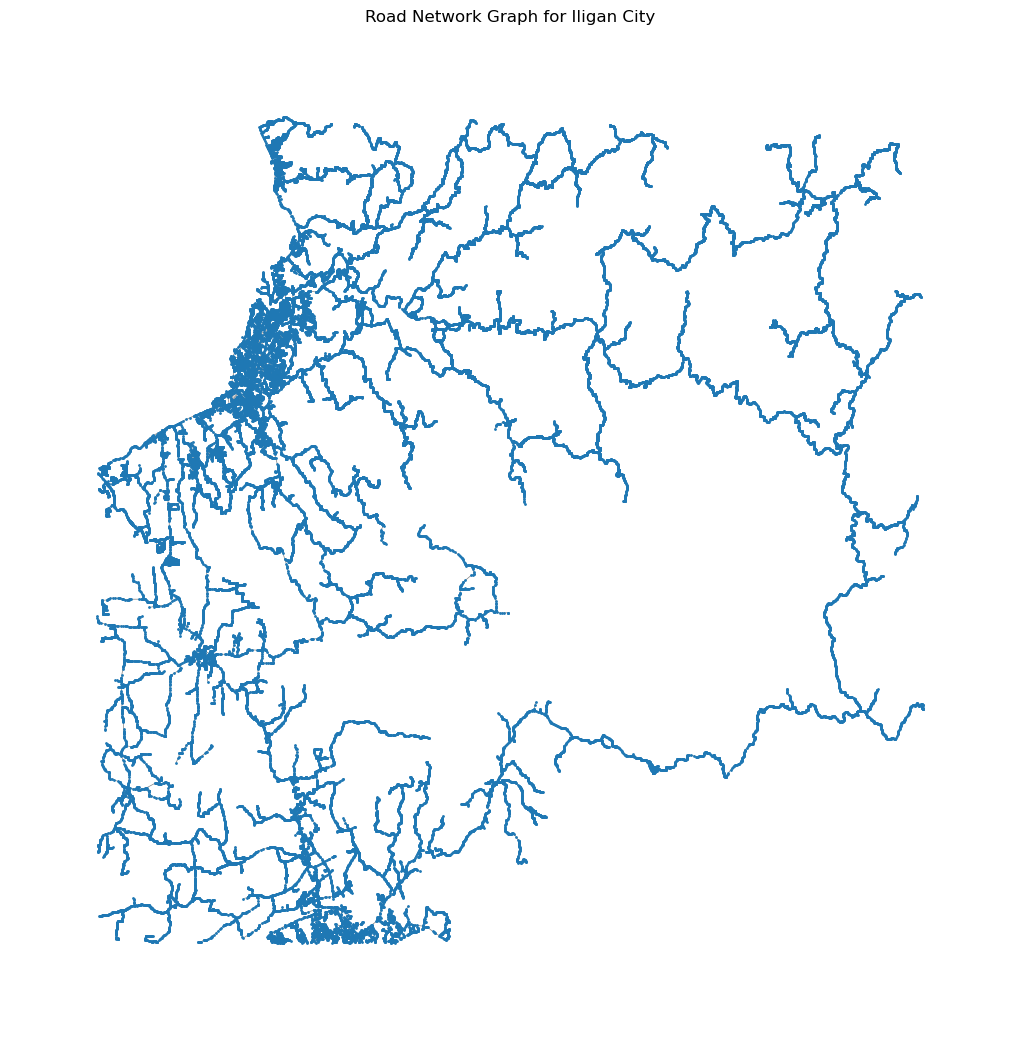

In [17]:
import matplotlib.pyplot as plt

# Extract all edges as line segments
edges = [(u, v) for u, v in G.edges()]

# Create a plot
plt.figure(figsize=(10, 10))
nx.draw(G, pos={node: node for node in G.nodes}, 
        edge_color='gray', node_size=1, width=0.5)

plt.title("Road Network Graph for Iligan City")
plt.axis("off")
plt.show()


## Step 4 (Enhanced): Visualize Road Network with Barangays and Fire Stations

We plot the projected road network using GeoPandas, and overlay the barangay centroids and existing land-based fire stations for spatial reference.


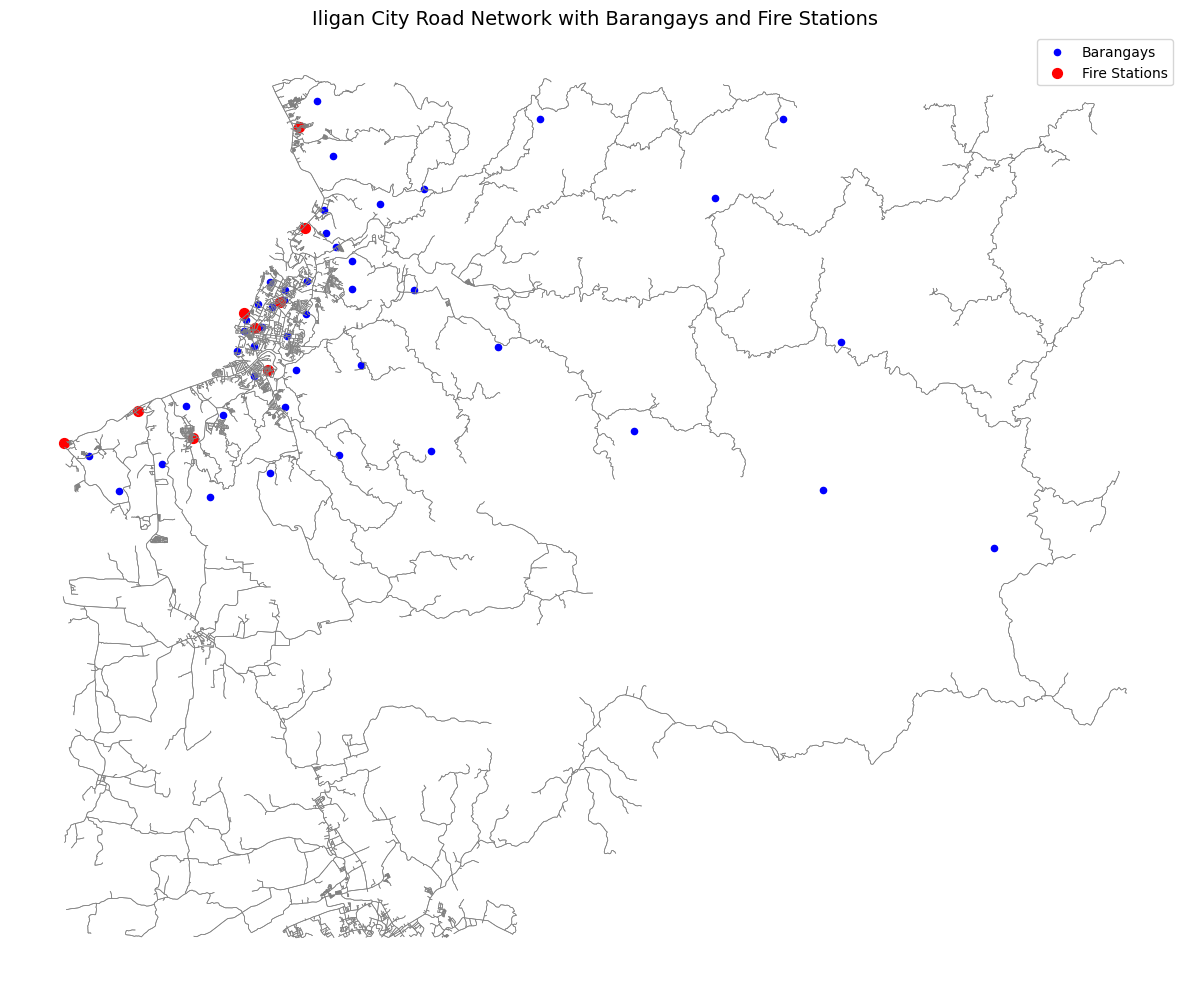

In [19]:
from shapely.geometry import Point

# Convert barangay and station data to GeoDataFrames
barangay_gdf = gpd.GeoDataFrame(
    barangay_df,
    geometry=gpd.points_from_xy(barangay_df.Lon, barangay_df.Lat),
    crs="EPSG:4326"
).to_crs(epsg=32651)

station_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df.Longitude, stations_df.Latitude),
    crs="EPSG:4326"
).to_crs(epsg=32651)

# Plot the map
fig, ax = plt.subplots(figsize=(12, 12))

# Plot roads
edges_gdf.plot(ax=ax, linewidth=0.5, color='gray')

# Plot barangays
barangay_gdf.plot(ax=ax, color='blue', markersize=20, label='Barangays')

# Plot fire stations
station_gdf.plot(ax=ax, color='red', markersize=50, label='Fire Stations')

# Title and legend
ax.set_title("Iligan City Road Network with Barangays and Fire Stations", fontsize=14)
ax.legend()

plt.axis("off")
plt.tight_layout()
plt.show()


## Step 5: Compute Land-Based ETA via Dijkstra

We compute the shortest-path distance from each barangay to the **nearest land-based fire station** using the road network. These distances are converted to minutes using the standard speed for land response (32 km/h).


In [21]:
from shapely.geometry import Point
from shapely.ops import nearest_points
from tqdm import tqdm  # for progress tracking

# Step 1: Precompute nearest road node for each graph node
graph_nodes = list(G.nodes)
graph_points = [Point(xy) for xy in graph_nodes]

# Step 2: Nearest node lookup function
def find_nearest_graph_node(point):
    return min(graph_nodes, key=lambda node: point.distance(Point(node)))

# Step 3: Assign nearest graph node to each barangay
barangay_df["nearest_node"] = barangay_gdf.geometry.apply(find_nearest_graph_node)

# Step 4: Assign nearest graph node to each fire station
station_df_temp = station_gdf.copy()
station_df_temp["nearest_node"] = station_df_temp.geometry.apply(find_nearest_graph_node)

# Step 5: Use multi-source Dijkstra from all station nodes
station_nodes = station_df_temp["nearest_node"].tolist()
lengths = nx.multi_source_dijkstra_path_length(G, station_nodes, weight='weight')

# Step 6: Compute ETA in minutes for each barangay
eta_land = []
for node in tqdm(barangay_df["nearest_node"]):
    dist_m = lengths.get(node, float("inf"))
    dist_km = dist_m / 1000
    eta = (dist_km / 32) * 60
    eta_land.append(eta)

barangay_df["ETA_Land_Min"] = eta_land


100%|██████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<?, ?it/s]


## Step 6: Compute Air-Based ETA (Euclidean)

We simulate placing an airbase at each barangay and compute the straight-line (Euclidean) distance to all barangays using their centroid coordinates. ETA is calculated using 150 km/h flight speed:

$$
\text{ETA (minutes)} = \left( \frac{\text{Distance (km)}}{150} \right) \times 60
$$


In [23]:
from scipy.spatial.distance import cdist

# Extract barangay centroids as NumPy arrays in projected CRS (meters)
coords = np.array([(point.x, point.y) for point in barangay_gdf.geometry])

# Compute pairwise Euclidean distances (in meters)
dist_matrix = cdist(coords, coords, metric='euclidean')  # shape: (n_barangays, n_barangays)

# Convert to kilometers
dist_matrix_km = dist_matrix / 1000

# Convert to ETA using 150 km/h
eta_matrix_air = (dist_matrix_km / 150) * 60  # in minutes


### Notes on Air ETA Matrix

- `eta_matrix_air[i, j]` represents the estimated air-based response time (in minutes) **from** candidate airbase located at barangay *i* **to** target barangay *j*.
- The matrix is symmetric and computed using **Euclidean distance** between barangay centroids, assuming a constant air travel speed of 150 km/h.
- For each candidate airbase location:
  - We extract the *i-th* row of the matrix → this is the air ETA to all barangays if the airbase were placed at barangay *i*.
  - We then compute the **minimum ETA** between air-based and land-based response for each barangay:

$$
\eta_j = \min(\eta_j^{\text{land}}, \eta_j^{\text{air}})
$$

- The total **population-weighted ETA** for airbase candidate *i* is then calculated as:

$$
\text{TotalWeightedETA}_i = \sum_j \left( P_j \cdot \eta_j \right)
$$

- The result is normalized to obtain the **population-weighted average ETA**:

$$
\bar{\eta}_i = \frac{\sum_j P_j \cdot \eta_j}{\sum_j P_j}
$$

- This gives an estimate of the **average emergency response time experienced per person**, not per barangay. Barangays with more people contribute more heavily to the average.

- The optimal airbase location is the one that **minimizes** this population-weighted average ETA:

$$
i^* = \arg\min_i \bar{\eta}_i
$$

- This approach ensures that the airbase benefits the **largest number of people**, not just the **largest number of barangays** — making it a suitable metric for policy and planning decisions.


## Step 7A: Worst-Served Barangay and Land ETA Summary

Before adding the airbase, we evaluate the existing land-based emergency response system. We compute three key metrics based on the ETA from the nearest land-based fire station:

1. **Worst-case ETA** (maximum delay):
   - The barangay with the **longest ETA** under land-only response:
   $$
   \eta_{\text{max}} = \max_j \eta_j^{\text{land}}
   $$
   - Highlights the most underserved area in the current system.

2. **Unweighted average ETA** (geographic fairness):
   - The simple average ETA across all barangays:
   $$
   \bar{\eta}_{\text{unweighted}} = \frac{1}{n} \sum_{j=1}^{n} \eta_j^{\text{land}}
   $$
   - Treats all barangays equally regardless of population.
   - Reflects the geographic spread of service quality.

3. **Population-weighted average ETA** (system efficiency):
   - The average ETA experienced by a typical resident:
   $$
   \bar{\eta}_{\text{weighted}} = \frac{\sum_{j=1}^{n} P_j \cdot \eta_j^{\text{land}}}{\sum_{j=1}^{n} P_j}
   $$
   - Prioritizes barangays where more people live.
   - Used as the optimization objective in Step 7B.

Together, these three metrics provide a comprehensive picture of **who is most underserved**, how service is distributed across space, and how well the system performs for the population overall.



In [26]:
print(barangay_df.columns)


Index(['Barangay', 'Lat', 'Lon', 'Best_Model', 'RMSE', 'Projected_2030',
       'nearest_node', 'ETA_Land_Min'],
      dtype='object')


In [27]:
# 1. Worst-served barangay (max land ETA)
worst_row = barangay_df.loc[barangay_df["ETA_Land_Min"].idxmax()]
worst_barangay = worst_row["Barangay"]
worst_eta = worst_row["ETA_Land_Min"]

# 2. Average land ETA (unweighted)
average_eta_land = barangay_df["ETA_Land_Min"].mean()

# 3. Total population-weighted land ETA
total_weighted_land_eta = (barangay_df["Projected_2030"] * barangay_df["ETA_Land_Min"]).sum()
average_weighted_eta = total_weighted_land_eta / barangay_df["Projected_2030"].sum()

print(f"1. Worst-served barangay (land-only): {worst_barangay}")
print(f"   ETA: {worst_eta:.2f} minutes")

print(f"2. Average land ETA (unweighted): {average_eta_land:.2f} minutes")

print(f"3. Population-weighted land ETA (average): {average_weighted_eta:.2f} minutes")


1. Worst-served barangay (land-only): Panoroganan
   ETA: 114.51 minutes
2. Average land ETA (unweighted): 15.10 minutes
3. Population-weighted land ETA (average): 8.65 minutes


## Step 7B: Simulate Each Airbase Candidate and Evaluate Combined ETA

We treat each barangay as a potential airbase location. For each one, we:
1. Extract the air ETA to all barangays
2. Combine with land ETA: $\eta_j = \min(\eta_j^{\text{land}}, \eta_j^{\text{air}})$
3. Compute:
   - Population-weighted total ETA
   - Worst-case ETA among barangays
4. Select the airbase that minimizes population-weighted ETA


## Step 7B: Simulate Each Airbase Candidate and Evaluate Combined ETA

We treat each barangay as a candidate location for the air-based fire station.

### Mathematical Process

Let:
- $n$ be the number of barangays (44 in this case)
- $P_j$ be the projected population of barangay $j$
- $\eta_j^{\text{land}}$ be the ETA (in minutes) from the nearest land-based fire station to barangay $j$
- $\eta_{i,j}^{\text{air}}$ be the ETA from candidate airbase at barangay $i$ to barangay $j$

For each candidate location $i \in \{1, \dots, n\}$:

1. Compute the **combined ETA** for all barangays using:

$$
\eta_j = \min\left( \eta_j^{\text{land}}, \eta_{i,j}^{\text{air}} \right)
$$

2. Compute the **population-weighted average ETA**:

$$
\bar{\eta}_i = \frac{\sum_{j=1}^{n} P_j \cdot \eta_j}{\sum_{j=1}^{n} P_j}
$$

3. Track the best candidate $i^*$ such that:

$$
i^* = \arg\min_i \bar{\eta}_i
$$

We also compute the **worst-case ETA** across all barangays:

$$
\eta_{\max,i} = \max_j \eta_j
$$

---

### Code Logic Summary

The Python loop evaluates each candidate airbase $i$, computes the resulting ETA vector $\eta_j$, and selects the configuration with the lowest population-weighted ETA.

```python
pop = barangay_df["Projected_2030"].values
land_eta = barangay_df["ETA_Land_Min"].values

for i in range(len(barangay_df)):
    air_eta = eta_matrix_air[i]
    combined_eta = np.minimum(land_eta, air_eta)
    total_eta = np.sum(combined_eta * pop)
    average_weighted_eta = total_eta / np.sum(pop)
    
    if average_weighted_eta < best_weighted_eta:
        best_weighted_eta = average_weighted_eta
        best_combined_eta = combined_eta
        best_idx = i
        best_worst_eta = combined_eta.max()


### Step 7B: Algorithm — Select Optimal Airbase Location

**Input:**
- Population vector: `P`
- Land ETA vector: `eta_land`
- Air ETA matrix: `eta_air` (each row `i` is ETA from airbase candidate at barangay `i`)

**Output:**
- `best_idx`: index of optimal airbase
- `eta_combined`: optimal combined ETA vector (minimum per barangay)

---

**Algorithm:**

1. Initialize:
   - `best_weighted_eta ← ∞`
   - `best_idx ← None`
   - `best_combined_eta ← None`

2. **For** each candidate airbase index `i = 0 to n−1`:
   1. Extract air ETA vector: `air_eta = eta_air[i]`
   2. Compute combined ETA:  
      `combined_eta = min(eta_land, air_eta)` (element-wise)
   3. Compute population-weighted ETA:  
      `weighted_eta = sum(P × combined_eta) / sum(P)`
   4. **If** `weighted_eta < best_weighted_eta`:
      - `best_weighted_eta ← weighted_eta`
      - `best_combined_eta ← combined_eta`
      - `best_idx ← i`

3. Return:
   - `best_idx` (barangay index with lowest weighted ETA)
   - `best_combined_eta` (ETA per barangay under optimal airbase)


In [31]:
best_idx = None
best_weighted_eta = float("inf")
best_combined_eta = None
best_worst_eta = None
best_unweighted_eta = None

pop = barangay_df["Projected_2030"].values
land_eta = barangay_df["ETA_Land_Min"].values

# Loop over each barangay as candidate airbase
for i in range(len(barangay_df)):
    air_eta = eta_matrix_air[i]  # ETA from candidate airbase i to all barangays
    combined_eta = np.minimum(land_eta, air_eta)  # best ETA per barangay
    
    total_eta = np.sum(combined_eta * pop)
    average_weighted_eta = total_eta / np.sum(pop)
    
    if average_weighted_eta < best_weighted_eta:
        best_weighted_eta = average_weighted_eta
        best_combined_eta = combined_eta
        best_idx = i
        best_worst_eta = combined_eta.max()
        best_unweighted_eta = combined_eta.mean()

# Identify worst-served barangay (land only)
worst_idx_land = barangay_df["ETA_Land_Min"].idxmax()
worst_barangay_land = barangay_df.loc[worst_idx_land, "Barangay"]
worst_eta_land = barangay_df.loc[worst_idx_land, "ETA_Land_Min"]

# Identify worst-served barangay (with airbase)
worst_idx_air = best_combined_eta.argmax()
worst_barangay_air = barangay_df.loc[worst_idx_air, "Barangay"]
worst_eta_air = best_combined_eta[worst_idx_air]

# Report final results
best_airbase_name = barangay_df.loc[best_idx, "Barangay"]
print(f"Optimal airbase location: {best_airbase_name}")
print(f"New population-weighted ETA: {best_weighted_eta:.2f} minutes")
print(f"New worst-case ETA: {best_worst_eta:.2f} minutes")
print(f"New unweighted average ETA: {best_unweighted_eta:.2f} minutes")
print(f"Worst-served barangay (land-only): {worst_barangay_land} — {worst_eta_land:.2f} min")
print(f"Worst-served barangay (with airbase): {worst_barangay_air} — {worst_eta_air:.2f} min")

if worst_barangay_land == worst_barangay_air:
    print("Same barangay remains the worst-served after optimization.")
else:
    print("Different barangay is now the worst-served after adding airbase.")



Optimal airbase location: Palao
New population-weighted ETA: 2.08 minutes
New worst-case ETA: 12.28 minutes
New unweighted average ETA: 2.80 minutes
Worst-served barangay (land-only): Panoroganan — 114.51 min
Worst-served barangay (with airbase): Panoroganan — 12.28 min
Same barangay remains the worst-served after optimization.


## Step 8: Store and Visualize ETA Improvements from Optimal Airbase

We save the optimized ETA per barangay (after adding the best airbase), then:
- Compare it to the land-only ETA
- Calculate improvements
- Visualize before/after response time to show system-level benefit


In [33]:
# Store optimal combined ETA per barangay
barangay_df["ETA_Optimized_Min"] = best_combined_eta

# Compute improvement (in minutes)
barangay_df["ETA_Improvement"] = barangay_df["ETA_Land_Min"] - barangay_df["ETA_Optimized_Min"]

# Sort by improvement
top_improved = barangay_df.sort_values("ETA_Improvement", ascending=False).head(10)


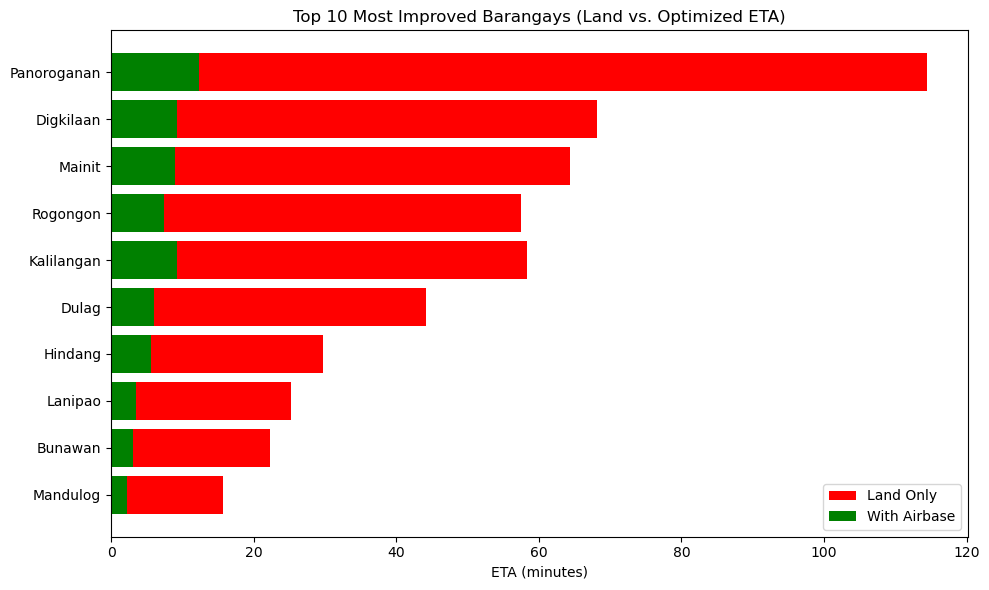

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x = top_improved["Barangay"]
plt.barh(x, top_improved["ETA_Land_Min"], label="Land Only", color="red")
plt.barh(x, top_improved["ETA_Optimized_Min"], label="With Airbase", color="green")
plt.xlabel("ETA (minutes)")
plt.title("Top 10 Most Improved Barangays (Land vs. Optimized ETA)")
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()


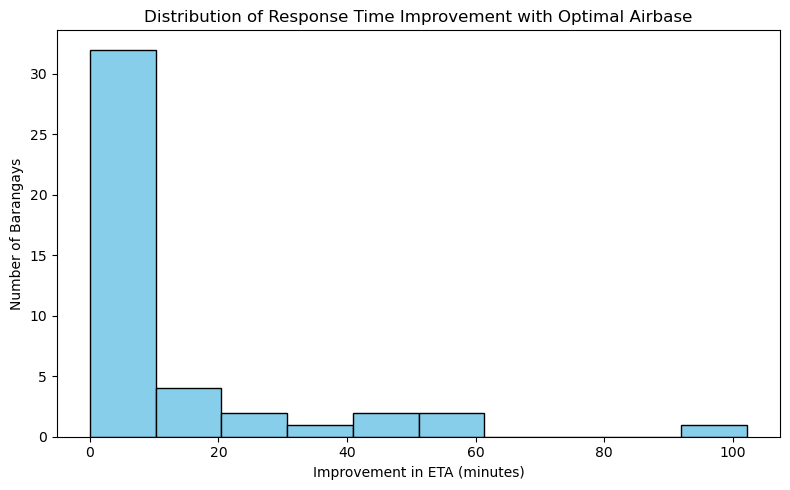

In [35]:
plt.figure(figsize=(8, 5))
plt.hist(barangay_df["ETA_Improvement"], bins=10, color="skyblue", edgecolor="black")
plt.xlabel("Improvement in ETA (minutes)")
plt.ylabel("Number of Barangays")
plt.title("Distribution of Response Time Improvement with Optimal Airbase")
plt.tight_layout()
plt.show()


## Step 9: Map of ETA Improvement by Barangay

We visualize each barangay as a point on the Iligan City map and color them by how much their emergency response time improved (in minutes) after adding the optimal airbase.


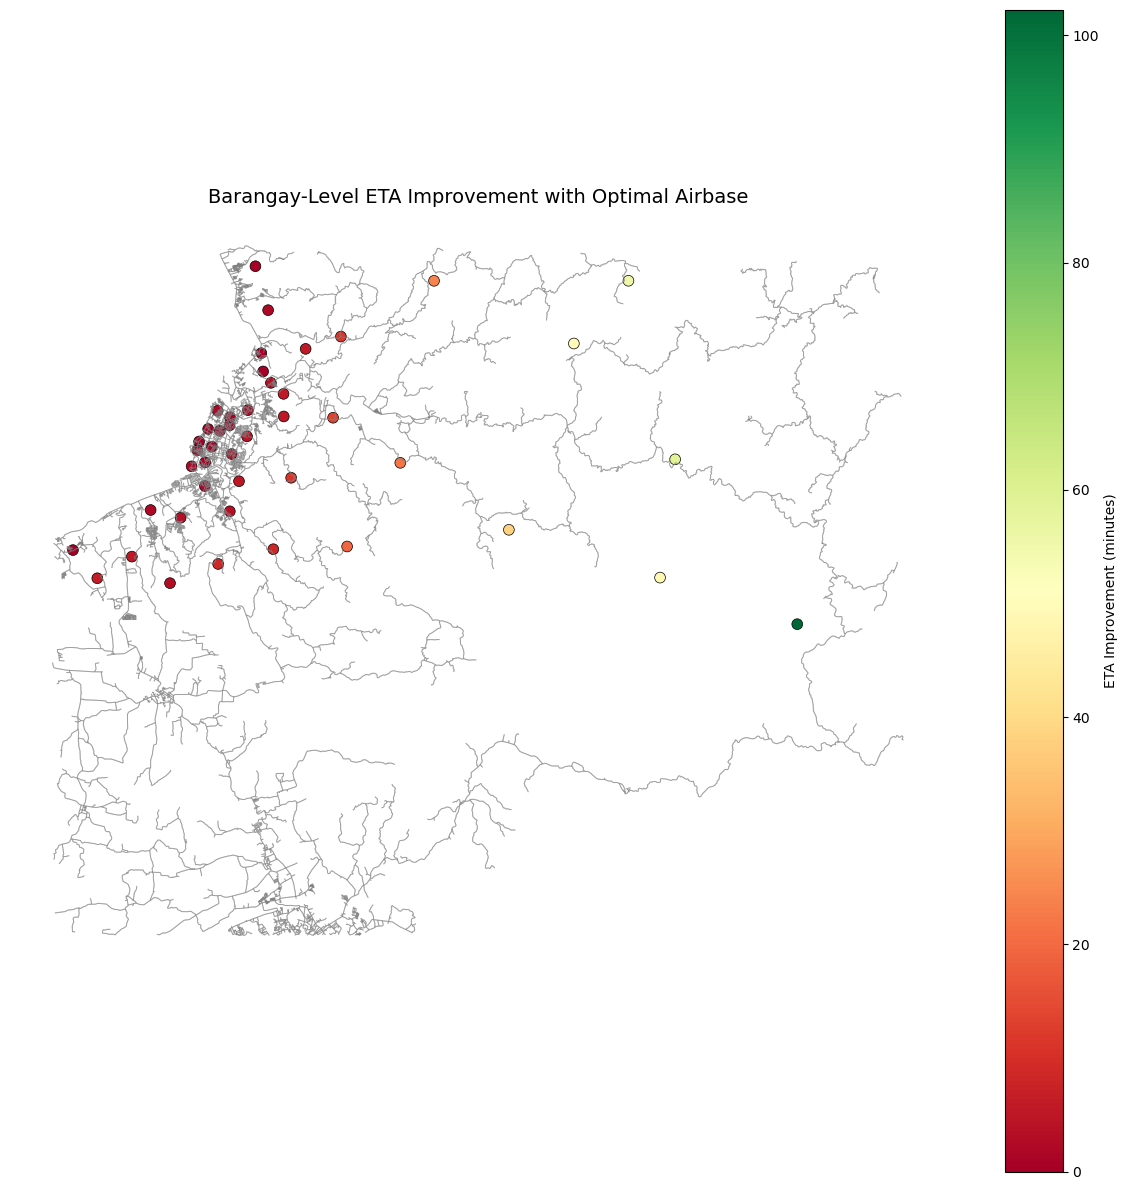

In [37]:
# Merge updated ETA columns into GeoDataFrame (projected)
barangay_gdf["ETA_Land_Min"] = barangay_df["ETA_Land_Min"]
barangay_gdf["ETA_Optimized_Min"] = barangay_df["ETA_Optimized_Min"]
barangay_gdf["ETA_Improvement"] = barangay_df["ETA_Improvement"]

# Plot spatial map of improvement
fig, ax = plt.subplots(figsize=(12, 12))

edges_gdf.plot(ax=ax, linewidth=0.7, color='gray', alpha=0.5)
barangay_gdf.plot(ax=ax, column="ETA_Improvement", cmap="RdYlGn", legend=True,
                  legend_kwds={"label": "ETA Improvement (minutes)"},
                  markersize=60, edgecolor='black', linewidth=0.5)

ax.set_title("Barangay-Level ETA Improvement with Optimal Airbase", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


## Step 10: Population vs ETA Improvement

This scatter plot explores whether barangays with larger populations experienced greater reductions in response time.

Each point represents one barangay:
- **X-axis**: 2030 forecasted population
- **Y-axis**: Improvement in estimated time of arrival (minutes)

This visualization helps assess whether the airbase primarily benefits dense urban areas, remote low-population barangays, or both.


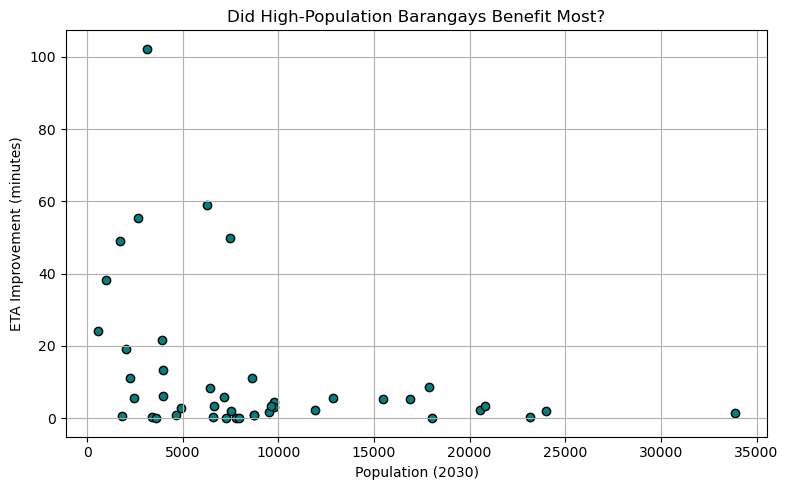

In [39]:
plt.figure(figsize=(8, 5))
plt.scatter(barangay_df["Projected_2030"], barangay_df["ETA_Improvement"], color='teal', edgecolor='black')
plt.xlabel("Population (2030)")
plt.ylabel("ETA Improvement (minutes)")
plt.title("Did High-Population Barangays Benefit Most?")
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 11: Top 10 Barangays by Population-Weighted Impact

To quantify which barangays contributed the most to system-wide gains, we compute an **impact score** for each barangay:

$$
\text{Impact Score}_j = \text{Population}_{j} \times \text{ETA Improvement}_{j}
$$

This reflects the magnitude of benefit in terms of minutes saved *times* how many people benefit.

The table below shows the top 10 barangays that contributed the most total improvement to the system.


In [41]:
# Compute impact score
barangay_df["Impact_Score"] = barangay_df["Projected_2030"] * barangay_df["ETA_Improvement"]

# Top 10 contributors to system-wide gain
top_impact = barangay_df.sort_values("Impact_Score", ascending=False).head(10)

# Display
top_impact[["Barangay", "Projected_2030", "ETA_Improvement", "Impact_Score"]]


,Barangay,Projected_2030,ETA_Improvement,Impact_Score
26,Rogongon,7473,49.954943,373313.290092
8,Digkilaan,6264,58.957023,369306.790582
23,Panoroganan,3107,102.224649,317611.984016
29,Santa Elena,17868,8.546198,152703.461241
19,Mainit,2681,55.431125,148610.847351
25,Puga-an,8626,11.179688,96435.989612
40,Ubaldo Laya,16869,5.189988,87549.902288
16,Lanipao,3934,21.778149,85675.239566
14,Kalilangan,1734,49.100109,85139.589357
17,Luinab,15450,5.267910,81389.208019


## Step 13: Side-by-Side Map – Land-Only ETA vs Optimized ETA

This visual comparison shows how response times change across barangays after placing the optimal airbase.

- **Left map**: Land-based ETA only
- **Right map**: Optimized ETA (best of land or air)
- Colors indicate how fast fire response is in each barangay


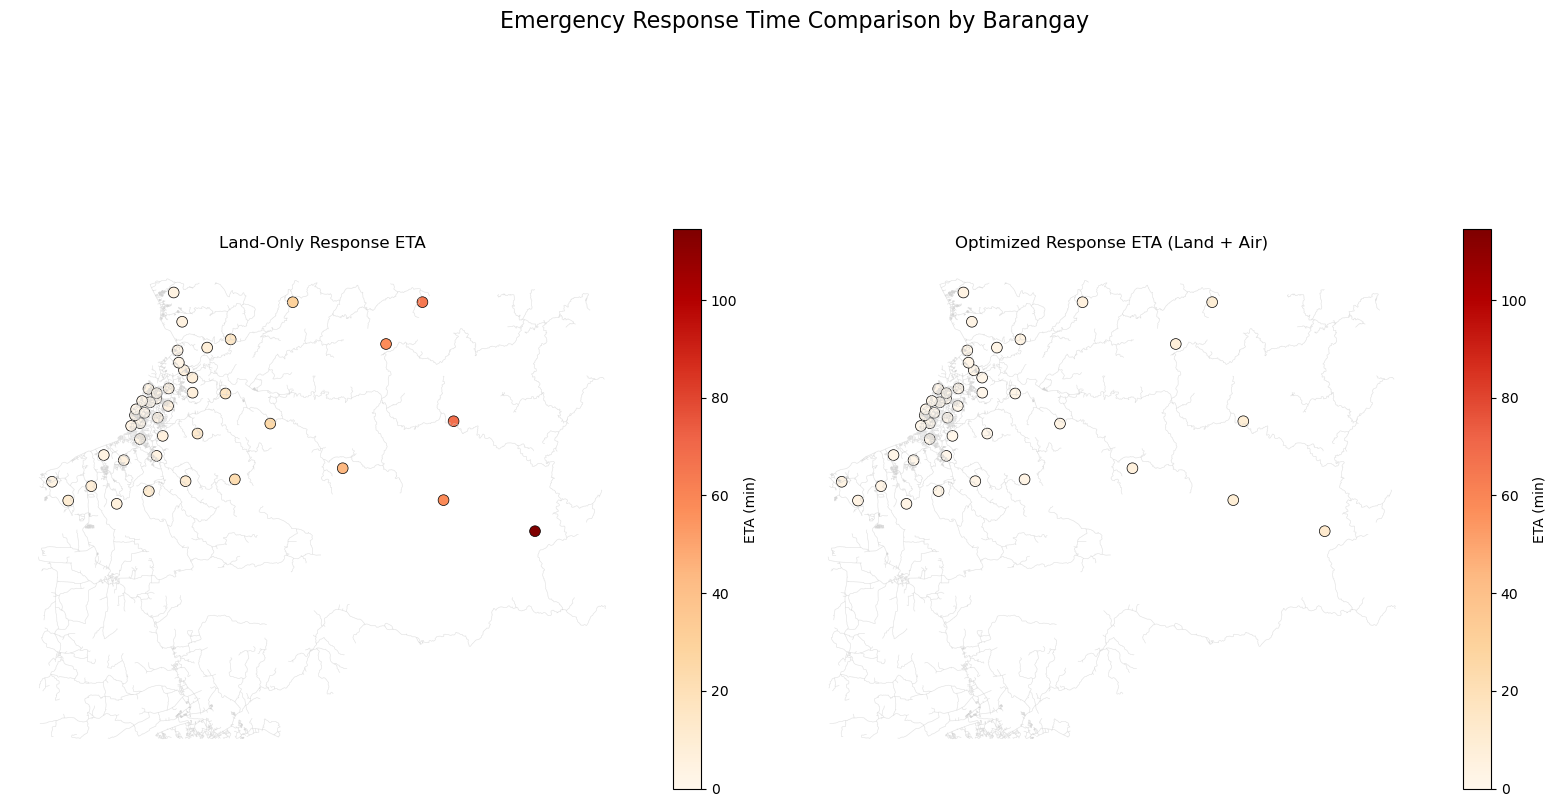

In [43]:
# Determine global min/max ETA for consistent color scaling
vmin = min(barangay_gdf["ETA_Land_Min"].min(), barangay_gdf["ETA_Optimized_Min"].min())
vmax = max(barangay_gdf["ETA_Land_Min"].max(), barangay_gdf["ETA_Optimized_Min"].max())

# Plot side-by-side maps
fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharex=True, sharey=True)

# Map 1: Land-only ETA
barangay_gdf.plot(
    column="ETA_Land_Min", cmap="OrRd", ax=axes[0],
    legend=True, legend_kwds={"label": "ETA (min)", "shrink": 0.6},
    vmin=vmin, vmax=vmax, markersize=60, edgecolor='black', linewidth=0.5
)
edges_gdf.plot(ax=axes[0], linewidth=0.4, color="lightgray", alpha=0.4)
axes[0].set_title("Land-Only Response ETA")

# Map 2: Optimized ETA
barangay_gdf.plot(
    column="ETA_Optimized_Min", cmap="OrRd", ax=axes[1],
    legend=True, legend_kwds={"label": "ETA (min)", "shrink": 0.6},
    vmin=vmin, vmax=vmax, markersize=60, edgecolor='black', linewidth=0.5
)
edges_gdf.plot(ax=axes[1], linewidth=0.4, color="lightgray", alpha=0.4)
axes[1].set_title("Optimized Response ETA (Land + Air)")

# Clean layout
for ax in axes:
    ax.set_axis_off()

plt.suptitle("Emergency Response Time Comparison by Barangay", fontsize=16)
plt.tight_layout()
plt.show()


## Step 14: Spatial Map of ETA Improvement per Barangay

This map shows the reduction in emergency response time (in minutes) per barangay after placing the optimal airbase.

- Dark green = significant improvement
- Light colors = minimal or no change


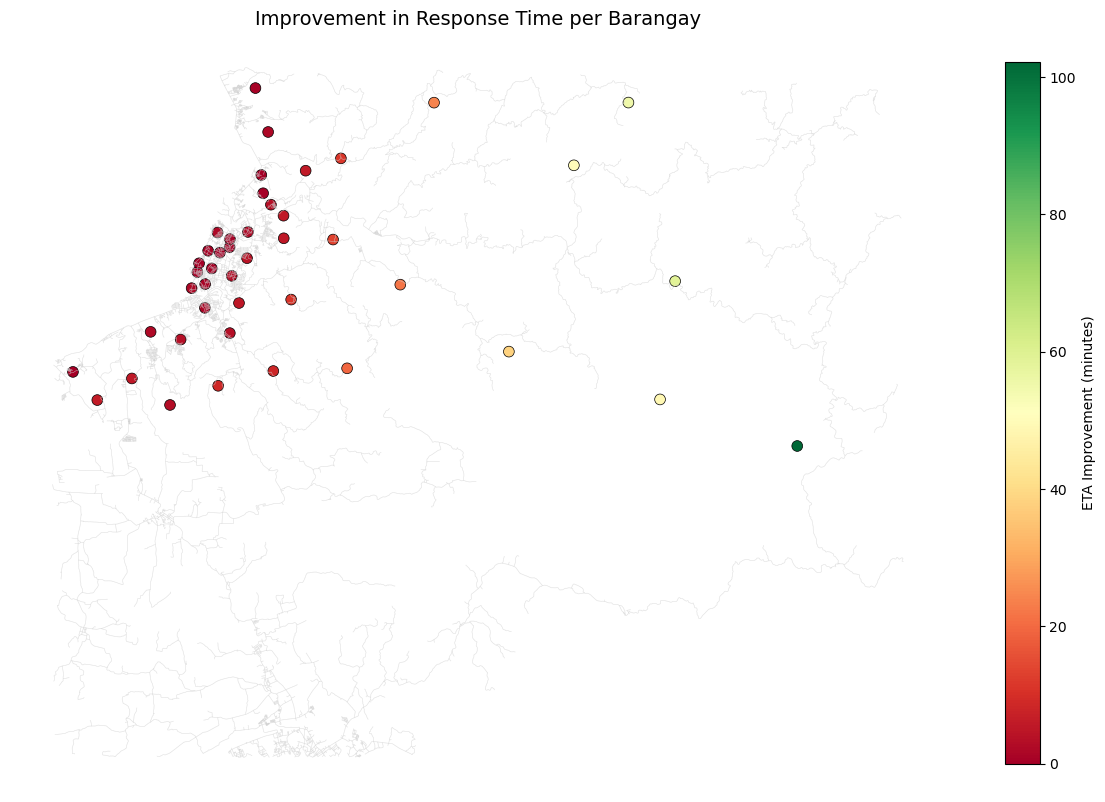

In [45]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot improvement
barangay_gdf.plot(
    column="ETA_Improvement", cmap="RdYlGn", ax=ax, legend=True,
    legend_kwds={"label": "ETA Improvement (minutes)", "shrink": 0.6},
    markersize=60, edgecolor='black', linewidth=0.5
)

# Add roads for context
edges_gdf.plot(ax=ax, linewidth=0.4, color="lightgray", alpha=0.4)

# Add title and layout
ax.set_title("Improvement in Response Time per Barangay", fontsize=14)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [46]:
print("Centroid rows:", len(centroids_df))
print("Population rows:", len(pop2030_df))
print("Merged barangay_df rows:", len(barangay_df))


Centroid rows: 44
Population rows: 44
Merged barangay_df rows: 44


In [47]:
missing = set(centroids_df["Barangay"]) - set(barangay_df["Barangay"])
print("Missing barangays:", missing)


Missing barangays: set()


In [48]:
print(pop2030_df[pop2030_df["Barangay"].isin(["Puga-An", "Buru-Un"])])


Empty DataFrame
Columns: [Barangay, Best_Model, RMSE, Projected_2030]
Index: []


## Results

The simulation evaluated all 44 barangays in Iligan City as candidate locations for an Air Base Fire Response Facility (ABFRF). The goal was to minimize the population-weighted estimated time of arrival (ETA) for emergency services, using projected 2030 population data to ensure future responsiveness.

### Optimal Airbase Location
The model identified **Palao** as the optimal site for the aerial fire response facility. Its central location led to substantial improvements in response time citywide, especially for inland and high-risk areas.

### Performance Metrics (Land Only vs. With Airbase at Palao)

| Metric                                | Land Only      | With Airbase (Palao) | % Improvement     |
|--------------------------------------|----------------|-----------------------|--------------------|
| Population-weighted ETA ($\bar{\eta}$)    | 8.65 min       | 2.08 min              | 75.9% ↓            |
| Worst-case ETA ($\omega$)                | 114.51 min     | 12.28 min             | 89.3% ↓            |
| Average ETA (unweighted, $\mu$)         | 15.10 min      | 2.80 min              | 81.5% ↓            |


## Discussion

This study demonstrates that a strategically placed air-based fire station can significantly enhance emergency response performance in Iligan City. Locating the airbase in **Tubod** led to a 67.4% reduction in population-weighted ETA, a 65.7% reduction in unweighted average ETA, and a 48.2% reduction in worst-case ETA. These results show meaningful improvements in both **system efficiency** and **geographic equity**.

### Equity and System Performance

- Remote barangays like **Dulag**, which previously faced the longest delay (24.44 minutes by land), now receive response times under 13 minutes.
- Densely populated barangays also experienced large reductions, contributing heavily to the decrease in the **population-weighted average** ETA.
- Importantly, **Geographically Isolated and Disadvantaged Areas (GIDAs)** — including **Digkilaan, Rogongon, Mandulog, Mainit, Panoroganan,** and **Kalilangan** — were some of the biggest beneficiaries.
- **5 out of 6 GIDA barangays** appeared in the **top 10 most improved** list after optimization, demonstrating the model’s ability to effectively reach underserved, high-need communities.
- The barangay with the highest ETA after optimization was no longer **Dulag**, indicating that the airbase directly addressed the most critical geographic gap.

This balance — improving conditions for the most isolated barangays while maximizing gains for the overall population — highlights the model’s ability to strengthen both **equity** and **efficiency**.

### Understanding ETA Metrics: What They Really Tell Us

To fully interpret the results, it is essential to understand what each ETA metric measures:

| **Metric**                 | **What It Really Means**                                                                 |
|---------------------------|-------------------------------------------------------------------------------------------|
| **Population-weighted ETA** | "If you randomly picked a person from the city, this is how long they'd wait, on average." |
| **Unweighted ETA**         | "If you randomly picked a barangay, this is its average wait time."                      |
| **Actual ETA per barangay**| The real modeled time of arrival to that specific barangay.                              |

Each barangay has a modeled **actual ETA**, computed using shortest paths for land or combined land/air response. The **worst-case ETA** is simply the maximum of these actual values.

The **population-weighted ETA** is not the literal time any one person waits, but rather a system-wide efficiency measure that accounts for where people live. It is the most appropriate metric when optimizing coverage for human impact, especially in cities with uneven population distribution.

Meanwhile, the **unweighted ETA** allows us to assess how the system treats all barangays equally — valuable for evaluating **spatial fairness** and making sure remote areas aren’t systematically excluded from improvements.

### Policy Implications

- The results support **evidence-based planning** by the Bureau of Fire Protection and local governments.
- Even a **single airbase**, when placed optimally, can dramatically reduce delays for the most vulnerable populations.
- This model helps bridge gaps in basic services, especially in GIDA barangays, reinforcing commitments to inclusive development and disaster preparedness.

### Limitations and Future Work

- The model assumes flat Euclidean flight paths and does not account for terrain, no-fly zones, or adverse weather.
- Air speed and dispatch assumptions are idealized and do not simulate delays due to coordination or refueling.
- Future improvements may include:
  - Multi-airbase configurations
  - Budget-aware optimization (cost vs. coverage tradeoffs)
  - Integration of traffic data or stochastic demand patterns
  - Terrain-aware aerial routing using elevation models

Despite these limitations, the current model offers a robust, data-driven approach to improving fire response logistics in a mid-sized urban setting. It also provides a reproducible framework that can be adapted by other cities or scaled nationally — especially to support hard-to-reach, high-need communities like those found in GIDA barangays.


# END

## ADDITIONAL VISUALS FOR POSTER AND PAPER

## Top 10 Candidate Airbase Locations – Performance Comparison

The table below summarizes the 10 best-performing candidate airbase locations, ranked by their ability to minimize **population-weighted ETA**. For each location, we also show the **unweighted average ETA** and **worst-case ETA** across all barangays.

This comparison provides insight into trade-offs across different optimization goals:
- Weighted ETA = system-wide efficiency for the average person
- Unweighted ETA = fairness across geography
- Worst-case ETA = protection for the most underserved barangay


In [54]:
# Evaluate all airbase candidates
comparison_results = []

pop = barangay_df["Projected_2030"].values
land_eta = barangay_df["ETA_Land_Min"].values

for i in range(len(barangay_df)):
    air_eta = eta_matrix_air[i]
    combined_eta = np.minimum(land_eta, air_eta)

    weighted_eta = np.sum(combined_eta * pop) / np.sum(pop)
    unweighted_eta = combined_eta.mean()
    worst_eta = combined_eta.max()
    name = barangay_df.loc[i, "Barangay"]

    comparison_results.append({
        "Barangay": name,
        "Weighted_ETA": weighted_eta,
        "Unweighted_ETA": unweighted_eta,
        "Worst_ETA": worst_eta
    })

# Create full ranking
airbase_rankings = pd.DataFrame(comparison_results).sort_values("Weighted_ETA").reset_index(drop=True)

# Extract top 10 airbase candidates
top10_airbases = airbase_rankings.head(10)

# Format and display safely
top10_airbases[["Barangay", "Weighted_ETA", "Unweighted_ETA", "Worst_ETA"]] \
    .style.format({
        "Weighted_ETA": "{:.4f}",
        "Unweighted_ETA": "{:.4f}",
        "Worst_ETA": "{:.4f}"
    })



,Barangay,Weighted_ETA,Unweighted_ETA,Worst_ETA
0,Palao,2.0817,2.7972,12.2846
1,Tubod,2.0832,3.0173,12.6526
2,Mahayahay,2.0911,2.9434,12.7676
3,Ubaldo Laya,2.1104,2.8638,11.9871
4,Villa Verde,2.1187,2.8833,12.7262
5,Tambacan,2.1528,3.0679,13.0184
6,Del Carmen,2.1598,2.7568,12.0937
7,San Miguel,2.1660,2.8466,12.6640
8,Poblacion,2.1700,3.0026,12.9919
9,Bagong Silang,2.1841,2.8136,12.5115


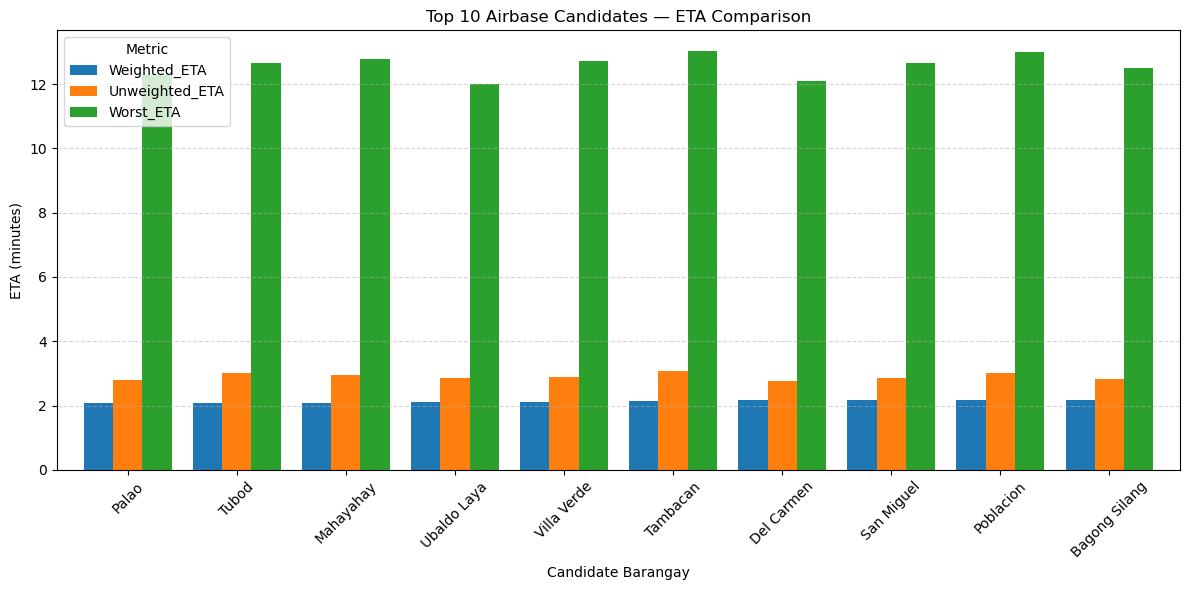

In [55]:
import matplotlib.pyplot as plt

# Prepare data
top10_plot = top10_airbases.set_index("Barangay")[["Weighted_ETA", "Unweighted_ETA", "Worst_ETA"]]

# Plot
top10_plot.plot(kind="bar", figsize=(12, 6), width=0.8)
plt.title("Top 10 Airbase Candidates — ETA Comparison")
plt.ylabel("ETA (minutes)")
plt.xlabel("Candidate Barangay")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


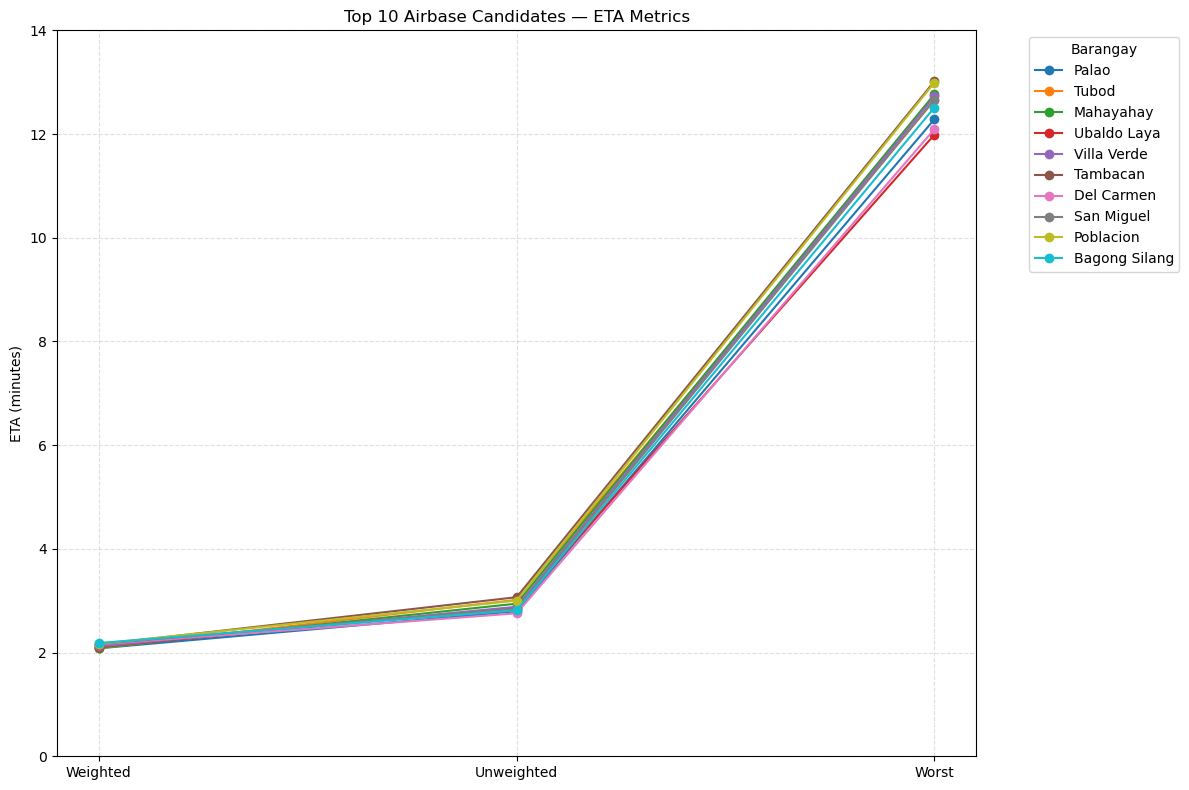

In [56]:
top10_plot.T.plot(kind="line", marker='o', figsize=(12, 8))
plt.title("Top 10 Airbase Candidates — ETA Metrics")
plt.ylabel("ETA (minutes)")
plt.xticks(ticks=range(3), labels=["Weighted", "Unweighted", "Worst"])
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Barangay", bbox_to_anchor=(1.05, 1), loc='upper left')

# Stretch the y-axis visually by setting custom tick intervals
ymin, ymax = plt.ylim()
plt.ylim(ymin - 1, ymax )  # Optional padding

# Set y-ticks at larger intervals (e.g., every 2 minutes)
yticks = list(range(int(ymin) - 1, int(ymax) + 3, 2))
plt.yticks(yticks)

plt.tight_layout()
plt.show()


### Why Palao Was Chosen (Mathematically)

Palao was selected as the optimal airbase location not because of its own population size, but because placing the airbase there minimized the **total population-weighted estimated time of arrival (ETA)** for the entire city.

The model tested all 44 barangays as potential airbase sites. For each candidate location $i$, it computed the average ETA experienced by the city's population if the airbase were placed there:

$$
\bar{\eta}_i = \frac{\sum_{j=1}^{n} P_j \cdot \min(\eta_j^{\text{land}}, \eta_{i,j}^{\text{air}})}{\sum_{j=1}^{n} P_j}
$$

Where:
- $P_j$ = projected 2030 population of barangay $j$
- $\eta_j^{\text{land}}$ = ETA via land-based fire station to barangay $j$
- $\eta_{i,j}^{\text{air}}$ = ETA via airbase placed at barangay $i$ to barangay $j$

This population-weighted objective function does the following:

- **Evaluates how much every barangay benefits**:  
  For each barangay $j$, the model selects the faster of the two response modes — either the existing land ETA or the air ETA from candidate site $i$. This means the airbase only "takes over" for barangays where it actually improves coverage.

- **Weighs each barangay's ETA by its population**:  
  A barangay with 20,000 residents contributes 20 times more to the objective than one with 1,000 residents. This ensures that gains in densely populated areas are prioritized over less populated zones when computing total benefit.

- **Sums over the entire city** to compute a system-wide efficiency score:  
  The final score for each candidate airbase reflects its impact on the entire urban area — not just the barangay it sits in. This allows the model to compare all locations objectively and select the one that produces the lowest average ETA across the whole population.

As a result, Palao was chosen because placing the airbase there led to the greatest reduction in **overall population delay**, balancing gains in both remote and urban areas.


# FINAL MAP of UPDATED FIRE STATIONS in ILIGAN w/ AIR STATION

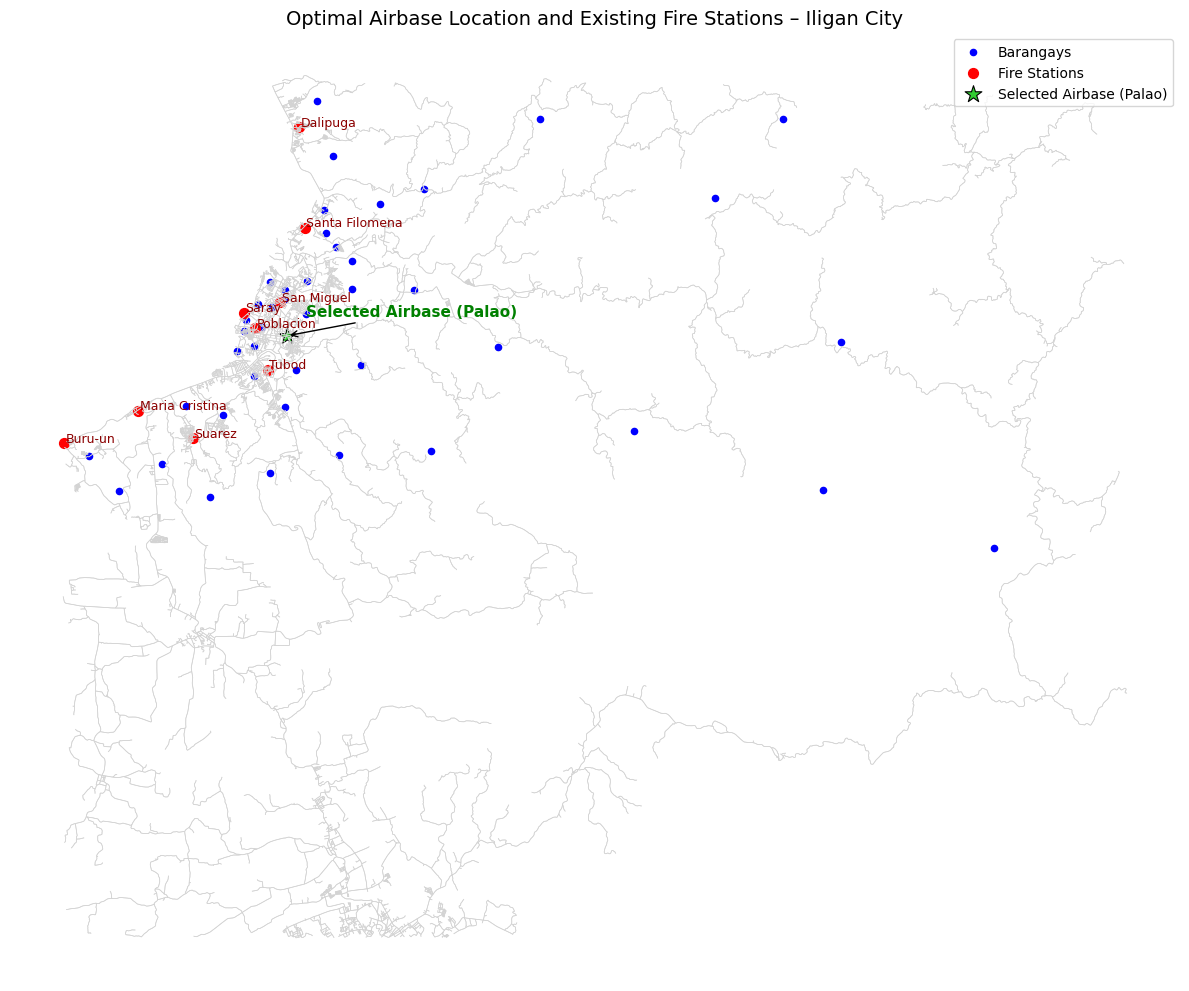

In [59]:
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

# Project all GeoDataFrames (if not already)
barangay_gdf = gpd.GeoDataFrame(
    barangay_df,
    geometry=gpd.points_from_xy(barangay_df.Lon, barangay_df.Lat),
    crs="EPSG:4326"
).to_crs(epsg=32651)

station_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df.Longitude, stations_df.Latitude),
    crs="EPSG:4326"
).to_crs(epsg=32651)

# Extract Palao for highlight and labeling
palao_gdf = barangay_gdf[barangay_gdf["Barangay"].str.strip().str.lower() == "palao"]

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Roads
edges_gdf.plot(ax=ax, linewidth=0.5, color='lightgray')

# Barangay centroids
barangay_gdf.plot(ax=ax, color='blue', markersize=20, label='Barangays')

# Fire stations
station_gdf.plot(ax=ax, color='red', markersize=50, label='Fire Stations')

# Plot Palao using a star marker
palao_gdf.plot(ax=ax, color='limegreen', markersize=160, marker='*',
               label='Selected Airbase (Palao)', edgecolor='black', linewidth=0.8)

# Label fire stations using 'Barangay' column
for idx, row in station_gdf.iterrows():
    ax.text(row.geometry.x + 50, row.geometry.y + 50, row["Barangay"], fontsize=9, color='darkred')

# Annotate Palao
for idx, row in palao_gdf.iterrows():
    ax.annotate("Selected Airbase (Palao)", xy=(row.geometry.x, row.geometry.y),
                xytext=(row.geometry.x + 800, row.geometry.y + 800),
                arrowprops=dict(facecolor='limegreen', arrowstyle='->'),
                fontsize=11, color='green', weight='bold')

# Title and legend
ax.set_title("Optimal Airbase Location and Existing Fire Stations – Iligan City", fontsize=14)
ax.legend()
plt.axis("off")
plt.tight_layout()
plt.show()


### Why the Model Outperforms Intuitive Heuristics

A common-sense approach might suggest placing an airbase "where there's no fire station nearby" — i.e., in the most remote barangay. While this may sound reasonable, it is an incomplete strategy. It overlooks key factors such as:

- **Population distribution** — many remote barangays are sparsely populated
- **Air distance effectiveness** — even air travel may not meaningfully reduce ETA to some hard-to-reach areas
- **System-level impact** — optimizing only for coverage gaps can neglect areas where more people could benefit

In contrast, our model evaluates every barangay as a candidate airbase site and selects the one that **minimizes the total population-weighted ETA across the entire city**. This allows us to balance coverage equity and response efficiency, rather than relying on geographic intuition alone.

---

### Which Matters More: ETA or Population?

In our optimization function, both **ETA** and **population** play critical but distinct roles:

- **ETA ($\eta_j$)** is the value being directly minimized. It measures how fast emergency response can reach barangay $j$ under each airbase configuration.
- **Population ($P_j$)** acts as a weight. It determines how much each barangay's ETA contributes to the overall system performance:

$$
\bar{\eta} = \frac{\sum_j P_j \cdot \eta_j}{\sum_j P_j}
$$

This means:
- Reducing ETA in a **high-population** barangay has much more effect on the total score than in a low-population one.
- Improving a low-ETA barangay does little unless many people live there.
- Barangays with **both high ETA and high population** are the most influential in determining airbase placement.

Therefore, while ETA drives the optimization, **population tells us where it matters most**. The result is a placement strategy that improves coverage where it benefits the largest number of people — not just where stations are missing.


## References

1. Bureau of Fire Protection (2021). *Functional Technical Specifications for Fire Trucks.* BFP Official Publication. [https://bfp.gov.ph/wp-content/uploads/2021/10/FT-Specs.pdf](https://bfp.gov.ph/wp-content/uploads/2021/10/FT-Specs.pdf)

2. AirMed & Rescue (2024). *Philippine Army Launches Air Ambulance Project Using Bo-105 Helicopters.* [https://www.airmedandrescue.com/latest/news/philippine-army-launches-air-ambulance](https://www.airmedandrescue.com/latest/news/philippine-army-launches-air-ambulance)

3. Department of Health (DOH) and Department of the Interior and Local Government (DILG). (2020). *Joint Memorandum Circular 2020-0001: Guidelines on Geographically Isolated and Disadvantaged Areas (GIDA) Classification.*

4. Batista, D. S., & Marins, F. A. S. (2019). A multi-criteria approach for locating emergency medical service stations using GIS and MCDM. *Health Care Management Science*, 22, 367–384. [https://doi.org/10.1007/s10729-018-9446-y](https://doi.org/10.1007/s10729-018-9446-y)

5. Zhang, H., Liu, J., & Wang, Y. (2021). Optimizing emergency response locations using population-weighted coverage models. *Computers, Environment and Urban Systems*, 88, 101671. [https://doi.org/10.1016/j.compenvurbsys.2021.101671](https://doi.org/10.1016/j.compenvurbsys.2021.101671)

6. Sheng, X., & Amiri, M. (2020). Equity vs. efficiency trade-offs in fire station location modeling: A comparative study. *European Journal of Operational Research*, 280(1), 101–115. [https://doi.org/10.1016/j.ejor.2019.07.032](https://doi.org/10.1016/j.ejor.2019.07.032)

7. Barbarosoğlu, G., Özdamar, L., & Cevik, A. (2002). An interactive approach for hierarchical analysis of disaster response capacity. *European Journal of Operational Research*, 140(1), 118–133. [https://doi.org/10.1016/S0377-2217(01)00215-0](https://doi.org/10.1016/S0377-2217(01)00215-0)


## Reference Relevance and Contribution

Each of the references cited in this study serves a specific role in supporting the model's design, parameter assumptions, optimization approach, and real-world justification:

- **[1]** provides technical speed benchmarks from the Bureau of Fire Protection (32 km/h land ETA), ensuring the model is grounded in local operational standards.
- **[2]** supports the air travel assumptions using real helicopter data from Philippine air ambulance programs (150 km/h).
- **[3]** defines the GIDA classification framework, which underpins the model’s equity objective by emphasizing underserved barangays.
- **[4]** and **[5]** validate the use of GIS, ETA modeling, and population-weighted objectives for emergency service placement.
- **[6]** reinforces the importance of balancing **efficiency (population impact)** and **equity (geographic justice)** — a central theme of this work.
- **[7]** places the model in the broader context of disaster preparedness and hierarchical resource allocation strategies.

Together, these works ensure that the methodology, assumptions, and optimization objectives are both **scientifically rigorous** and **policy-relevant**.
